In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import signal
import matplotlib.pylab as pl
import time
import cv2 as cv
import ot
import math

# Define Sliced Wass & Sliced Wass Grad

In [4]:
def SWgrad(u,v,nbProj):#Pour deux images de même taille
    N = u.shape[0]
    M = u.shape[1]
    d = u.shape[2]
    random_state = np.random.RandomState(None)
    Teta = random_state.normal(0., 1., [nbProj, d])
    np.linalg.norm(Teta)
    norm = np.linalg.norm(Teta, ord=2, axis=1, keepdims=True)
    Teta = Teta / norm
    Res = np.zeros((N,M,d))
    for i in range(nbProj):
        uteta = np.zeros(N*M)
        vteta = np.zeros(N*M)
        for j in range(N*M):#np.int(np.floor(i/M)), np.int(i - np.floor(i/M)*M)
            uteta[j] = np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
            vteta[j] = np.dot(v[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
        Iu_sorted = np.argsort(uteta)
        Iv_sorted = np.argsort(vteta)
        sigma = np.zeros(N*M)
        sigma[Iu_sorted] = Iv_sorted
        for j in range(N*M):
                Res[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] = Res[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] + np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] - v[np.int(np.floor(sigma[j]/M)), np.int(sigma[j] - np.floor(sigma[j]/M)*M)], Teta[i])*Teta[i]
        
        
    Res = Res*2/nbProj
    
    return Res
                
    
def SW(u,v,nbProj):#Pour deux images de même taille 
    N = u.shape[0]
    M = u.shape[1]
    d = u.shape[2]
    random_state = np.random.RandomState(None)
    Teta = random_state.normal(0., 1., [nbProj, d])
    np.linalg.norm(Teta)
    norm = np.linalg.norm(Teta, ord=2, axis=1, keepdims=True)
    Teta = Teta / norm
    SW = 0
    for i in range(nbProj):
        uteta = np.zeros(N*M)
        vteta = np.zeros(N*M)
        for j in range(N*M):#np.int(np.floor(i/M)), np.int(i - np.floor(i/M)*M)
            uteta[j] = np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
            vteta[j] = np.dot(v[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
        u_sorted = np.sort(uteta)
        v_sorted = np.sort(vteta)
        SW = SW + np.sum((u_sorted - v_sorted)**2)
    SW = SW/nbProj
    
    return SW
    

# Test du Gradient de la Sliced Wasserstein

Pour celà on va faire une descente de gradient pour minimiser la fonction :

Résoudre le problème : $\underset{Z_1}{\inf} 
 SW_2^2(L_H , Z_1) + ||Z_1 - XR||^2$

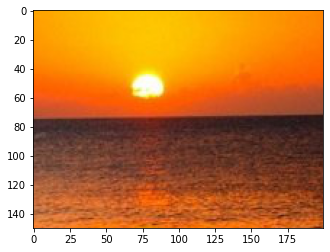

In [5]:
I1 = plt.imread('../data/coucher.jpg')
X = I1[100:250, 450:650, :]/255
b = X.shape[2]
nL = X.shape[0]
nC = X.shape[1]
plt.imshow(X)

In [6]:
def echantillonne_image(inp,K,adjoint):
    sx , sy, d = inp.shape[0], inp.shape[1], inp.shape[2]
    
    if adjoint==0: #sous-echantillonnage
        Sx = math.floor(sx/K)
        Sy = math.floor(sy/K)
        out = np.zeros([Sx,Sy,d])
        for x in range(Sx):
            for y in range(Sy):
                tmp=0
                for k in range(K):
                    for l in range(K):
                        tmp += inp[K*x+k,K*y+l, :]
                out[x,y,:]=tmp
                
    else: #sur-echantillonnage
        Sx = sx*K
        Sy = sy*K
        out = np.zeros([Sx,Sy,d])
        for x in range(sx):
            for y in range(sy):
                for k in range(K):
                    for l in range(K):
                        out[K*x+k,K*y+l]= inp[x,y]
    
    return out/(K*K)

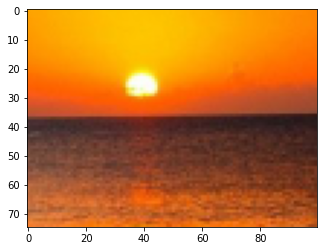

In [7]:
L_H = echantillonne_image(X, 2, 0)
plt.imshow(L_H)

La fonction à minimiser est $f(Z1) = SW_2^2(L_H , Z_1) + ||Z_1 - XR||^2$

In [8]:
def Fonctionnelle_1(Z1, X, L_H, K_ech, Lbd_H, Lbd_reg, nbProj):
    F = Lbd_reg*np.linalg.norm(Z1 - echantillonne_image(X, K_ech, 0))
    SW1 = Lbd_H*SW(Z1, L_H, nbProj)
    return F + SW1

In [15]:
def gradientDescente_hyper(L_H, X, K_ech, Lbd_H, Lbd_reg, nbIt, nbProj, pas):
    Z1 = np.random.rand(L_H.shape[0], L_H.shape[1], L_H.shape[2])
    
    ErrR=[np.linalg.norm(Z1-L_H)]#distance a l'image théorique
    Fct = [Fonctionnelle_1(Z1, X, L_H, K_ech, Lbd_H, Lbd_reg, nbProj)]#fonctionnelle a minimiser

    for i in range(nbIt):
        grad = Lbd_H*SWgrad(Z1,L_H,nbProj) + 2*Lbd_reg*(Z1 - echantillonne_image(X, K_ech, 0))
        Z1 = Z1 - pas*grad
        Fct.append(Fonctionnelle_1(Z1, X, L_H, K_ech, Lbd_H, Lbd_reg, nbProj))
        ErrR.append(np.linalg.norm(Z1-L_H))
        if(i%10 == 0):
            print( 'iter = ', i ,"fonction = ",Fonctionnelle_1(Z1, X, L_H, K_ech, Lbd_H, Lbd_reg, nbProj), "distance à la solution = " , np.linalg.norm(Z1-L_H))

    return Z1, ErrR, Fct

In [16]:
Z1, ErrR, Fct = gradientDescente_hyper(L_H, X, 2, 1, 0.1, 100, 5, 0.1)

iter =  0 fonction =  915.273301552619 distance à la solution =  62.94791182244152
iter =  10 fonction =  129.728296858929 distance à la solution =  39.81901903452154
iter =  20 fonction =  56.080731874301584 distance à la solution =  31.050087412868507
iter =  30 fonction =  21.85282736470297 distance à la solution =  25.753079523550397
iter =  40 fonction =  13.071070009272145 distance à la solution =  21.56149389428296
iter =  50 fonction =  6.7404148734061575 distance à la solution =  17.975703297764344
iter =  60 fonction =  3.9649000949076427 distance à la solution =  14.852487891605374
iter =  70 fonction =  3.084441019352754 distance à la solution =  12.2514191683616
iter =  80 fonction =  1.7466908627507998 distance à la solution =  10.03226800973898
iter =  90 fonction =  1.4813876276173057 distance à la solution =  8.203077220939463


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


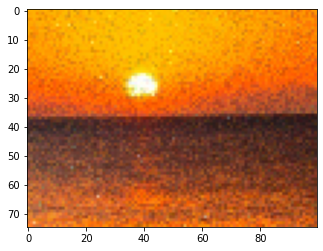

In [17]:
plt.imshow(Z1)

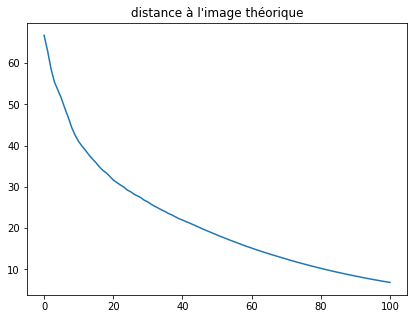

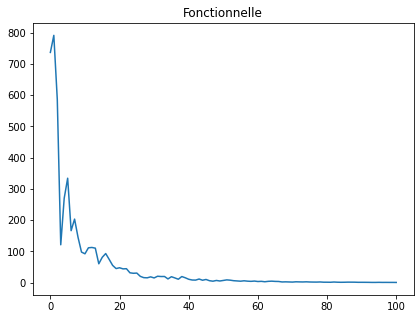

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(ErrR)
plt.title("distance à l'image théorique")

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.plot(Fct)
plt.title("Fonctionnelle")

plt.show()

Test sur le deuxième problème : 


Résoudre le problème : $\underset{Z_2}{\inf} 
 SW_2^2(L_M, Z_2) + ||Z_2 - LX||^2$

In [27]:
def spectrale_degradation(img, d_m, d_h, adjoint):
    if(adjoint == 0):
        d = img.shape[2]
        out = np.zeros((img.shape[0], img.shape[1], d_m))
        for i in range(d_m):
            for j in range(d):
                out[:,:,i] = out[:,:,i] + img[:,:,j]
            
            out[:,:,i] = out[:,:,i]/d
        return out
    else :
        d = img.shape[2]
        out = np.zeros((img.shape[0], img.shape[1], d_h))
        for i in range(d_h):
            out[:,:,i] = 1/3*img[:,:,0]
        return out   


def filtre_Bayer(img,adjoint):
    sx, sy = np.shape(img)[:2]
    
    if adjoint == 0:
        out = np.zeros((sx,sy,1)) # Notre opérateur renvoi une image dans R^(N^2)
        for i in range(sx):
            for j in range(sy):
                if(i%2 == j%2 == 0):
                    out[i,j] = img[i,j][2] ## Si les coordonnées sont paires on prend u_b
                else : 
                    if (i%2 == j%2 == 1):
                        out[i,j] = img[i,j][0] ## Si elles sont impaires on prend u_r
                    else:
                        out[i,j] = img[i,j][1] ## Sinon on prend u_g
    
    
    else :
        out = np.zeros((sx,sy,3))  ## L'adjoint renvoi une image dans (R^3)^(N^2)
        for i in range(sx):
            for j in range(sy):
                if(i%2 == j%2 == 0):
                    out[i,j] = np.array([0,0,img[i,j]])  
                else : 
                    if (i%2 == j%2 == 1):
                        out[i,j] = np.array([img[i,j],0,0])
                    else:
                        out[i,j] = np.array([0,img[i,j],0])
                
                  
    return out

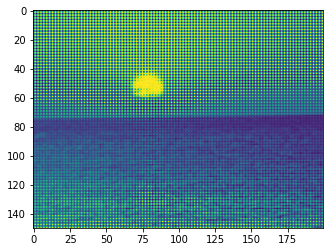

In [28]:
L_M = filtre_Bayer(X, 0)
plt.imshow(L_M)

La fonction à minimiser est $f(Z2) = SW_2^2(L_M , Z_2) + ||Z_2 - LX||^2$

In [45]:
def Fonctionnelle_2(Z2, X, L_H, Lbd_M, Lbd_reg, nbProj):
    F = Lbd_reg*np.linalg.norm(Z2 - filtre_Bayer(X, 0))
    SW2 = Lbd_M*SW(Z2, L_M, nbProj)
    return F + SW2

In [46]:
def gradientDescente_multi(L_M, X, Lbd_M, Lbd_reg, nbIt, nbProj, pas):
    Z2 = np.random.rand(L_M.shape[0], L_M.shape[1], L_M.shape[2])
    
    ErrR=[]#distance a l'image théorique
    Fct = []#fonctionnelle a minimiser

    for i in range(nbIt):
        grad = Lbd_M*SWgrad(Z2,L_M,nbProj) + 2*Lbd_reg*(Z2 - filtre_Bayer(X, 0))
        Z2 = Z2 - pas*grad
        Fct.append(Fonctionnelle_2(Z2, X, L_M, Lbd_M, Lbd_reg, nbProj))
        ErrR.append(np.linalg.norm(Z2-L_M))
        if(i%10 == 0):
            print( 'iter = ', i ,"fonction = ",Fonctionnelle_2(Z2, X, L_M, Lbd_M, Lbd_reg, nbProj), "distance à la solution = " , np.linalg.norm(Z2-L_M))
        
    return Z2, ErrR, Fct

In [47]:
Z2, ErrR, Fct = gradientDescente_multi(L_M, X, 1, 1, 50, 5, 0.1)

iter =  0 fonction =  340.92377806239597 distance à la solution =  59.10801266348993
iter =  10 fonction =  9.263490517109325 distance à la solution =  6.755915942373291
iter =  20 fonction =  0.7768354537246646 distance à la solution =  0.7277634360825155
iter =  30 fonction =  0.3526283680687914 distance à la solution =  0.278367002370163
iter =  40 fonction =  0.3512604127141813 distance à la solution =  0.27542241654130206


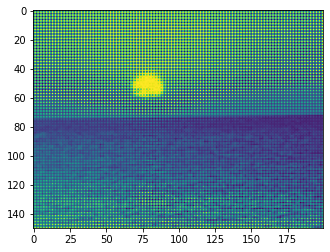

In [48]:
plt.imshow(Z2)

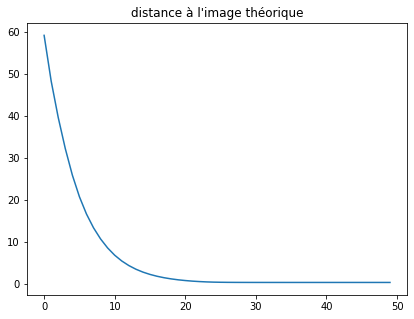

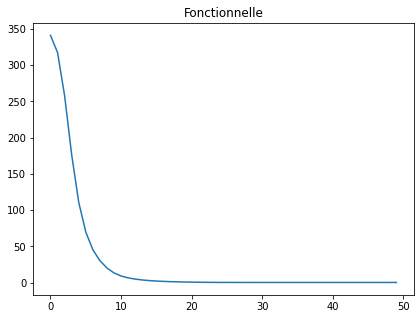

In [49]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(ErrR)
plt.title("distance à l'image théorique")

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.plot(Fct)
plt.title("Fonctionnelle")

plt.show()

# Test pour différentes valeurs de Lambda

Descente de gradient avec condition d'arrêt.

In [20]:
def gradientDescente_hyper_arret(L_H, X, K_ech, Lbd_H, Lbd_reg, nbProj, pas):
    Z1 = np.random.rand(L_H.shape[0], L_H.shape[1], L_H.shape[2])
    
    ErrR=[np.linalg.norm(Z1-L_H)]#distance a l'image théorique
    Fct = [Fonctionnelle_1(Z1, X, L_H, K_ech, Lbd_H, Lbd_reg, nbProj)]#fonctionnelle a minimiser
    
    i = 0
    while(Fct[i] >1 & i <10000):
        grad = Lbd_H*SWgrad(Z1,L_H,nbProj) + 2*Lbd_reg*(Z1 - echantillonne_image(X, K_ech, 0))
        Z1 = Z1 - pas*grad
        Fct.append(Fonctionnelle_1(Z1, X, L_H, K_ech, Lbd_H, Lbd_reg, nbProj))
        ErrR.append(np.linalg.norm(Z1-L_H))
        if(i%10 == 0):
            print( 'iter = ', i ,"fonction = ",Fonctionnelle_1(Z1, X, L_H, K_ech, Lbd_H, Lbd_reg, nbProj), "distance à la solution = " , np.linalg.norm(Z1-L_H))
        
        i = i+1

    return Z1, ErrR, Fct

In [21]:
Z1_1, ErrR_1, Fct_1 = gradientDescente_hyper_arret(L_H, X, 2, 1, 1, 5, 0.1)
Z1_2, ErrR_2, Fct_2 = gradientDescente_hyper_arret(L_H, X, 2, 1, 0.5, 5, 0.1)
Z1_3, ErrR_3, Fct_3 = gradientDescente_hyper_arret(L_H, X, 2, 1, 0.1, 5, 0.1)
Z1_4, ErrR_4, Fct_4 = gradientDescente_hyper_arret(L_H, X, 2, 1, 0.01, 5, 0.1)

iter =  0 fonction =  552.594003724205 distance à la solution =  51.30200820106887
iter =  10 fonction =  5.79613981556864 distance à la solution =  4.160298020489284
iter =  0 fonction =  551.8887031225603 distance à la solution =  58.268054202645594
iter =  10 fonction =  27.825337828188772 distance à la solution =  16.05569014044918
iter =  20 fonction =  4.024818008564805 distance à la solution =  4.829486985097689
iter =  30 fonction =  0.8363425958010058 distance à la solution =  1.5901618966603772
iter =  0 fonction =  580.4026288842422 distance à la solution =  63.52587668653074
iter =  10 fonction =  126.65274061671997 distance à la solution =  40.65732844732133
iter =  20 fonction =  35.76757917377306 distance à la solution =  31.2320854540224
iter =  30 fonction =  23.71595268402344 distance à la solution =  26.252228543908473
iter =  40 fonction =  13.113002368239963 distance à la solution =  21.97473689770396
iter =  50 fonction =  9.364198792886874 distance à la solution 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image rec


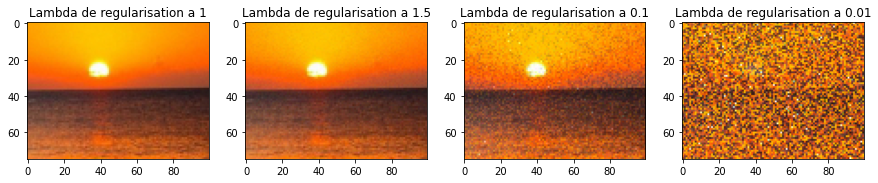

In [29]:
print('Image rec')

plt.figure(figsize = (15,15))
plt.subplot(1,4,1)
plt.title("Lambda de regularisation a 1")
plt.imshow(Z1_1)
plt.subplot(1,4,2)
plt.title("Lambda de regularisation a 0.5")
plt.imshow(Z1_2)
plt.subplot(1,4,3)
plt.title("Lambda de regularisation a 0.1")
plt.imshow(Z1_3)
plt.subplot(1,4,4)
plt.title("Lambda de regularisation a 0.01")
plt.imshow(Z1_4)

plt.show()

distance à image théorique


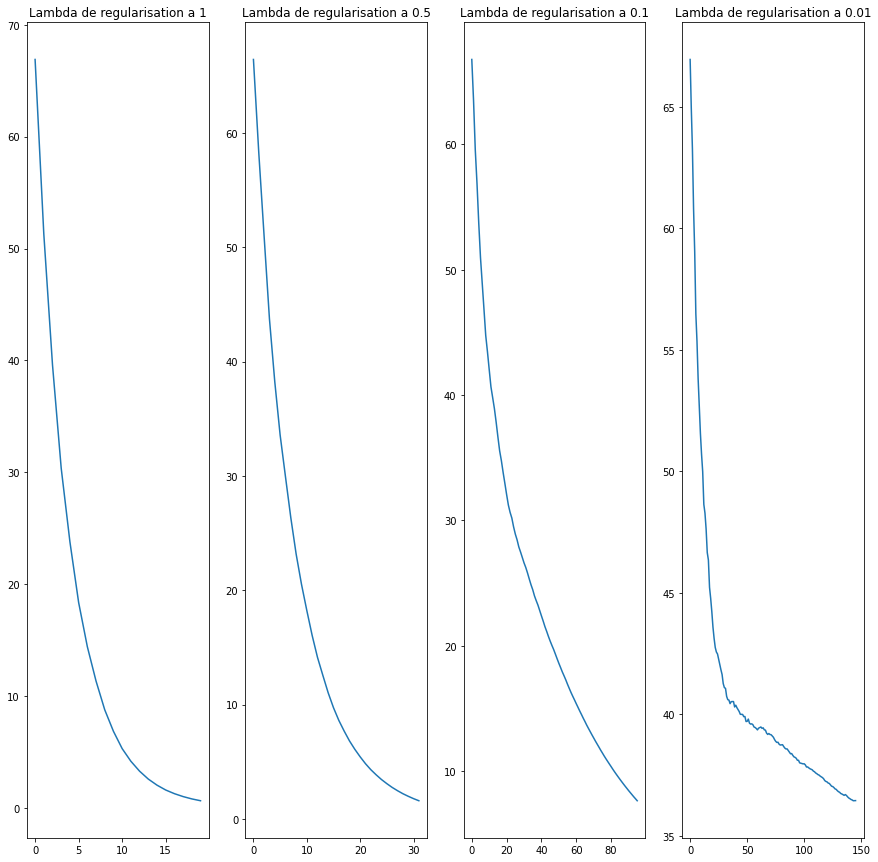

In [28]:
print('distance à image théorique')

plt.figure(figsize = (15,15))
plt.subplot(1,4,1)
plt.title("Lambda de regularisation a 1")
plt.plot(ErrR_1)
plt.subplot(1,4,2)
plt.title("Lambda de regularisation a 0.5")
plt.plot(ErrR_2)
plt.subplot(1,4,3)
plt.title("Lambda de regularisation a 0.1")
plt.plot(ErrR_3)
plt.subplot(1,4,4)
plt.title("Lambda de regularisation a 0.01")
plt.plot(ErrR_4)

plt.show()

Fonctionnelle


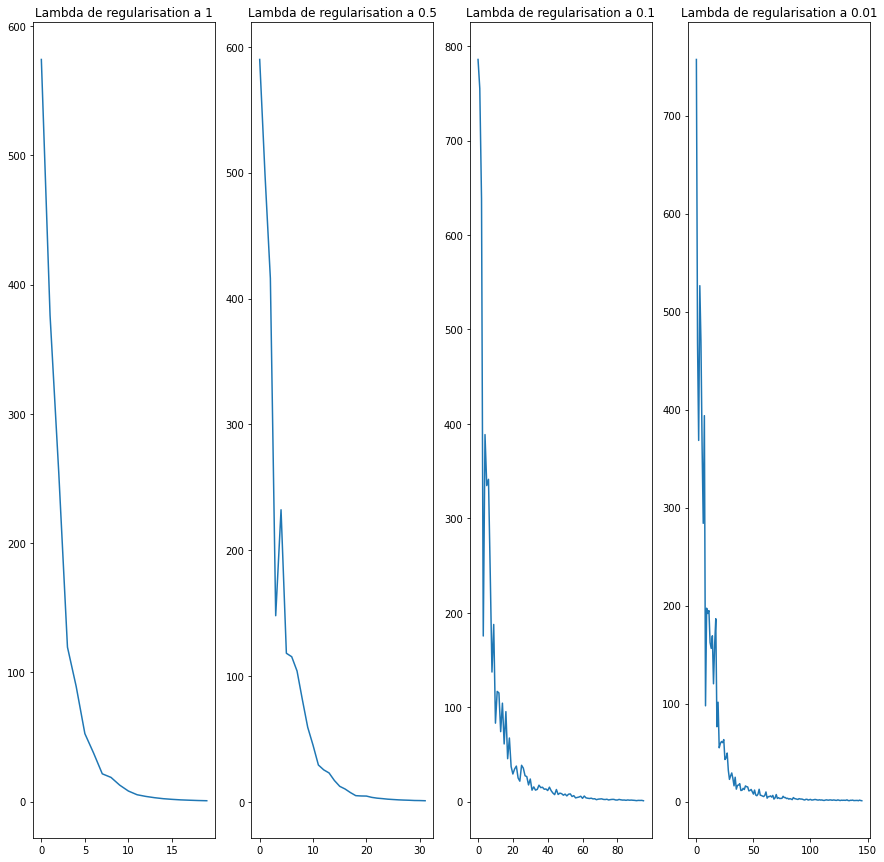

In [30]:
print('Fonctionnelle')

plt.figure(figsize = (15,15))
plt.subplot(1,4,1)
plt.title("Lambda de regularisation a 1")
plt.plot(Fct_1)
plt.subplot(1,4,2)
plt.title("Lambda de regularisation a 0.5")
plt.plot(Fct_2)
plt.subplot(1,4,3)
plt.title("Lambda de regularisation a 0.1")
plt.plot(Fct_3)
plt.subplot(1,4,4)
plt.title("Lambda de regularisation a 0.01")
plt.plot(Fct_4)

plt.show()

# Pas de Armijo

In [37]:
def Armijo(out,grad,X,L_H,K_ech,Lbd_H,Lbd_reg,nbProj,sigma,teta):
    i = 0
    pasMax = 1.0
    pas = pasMax
    fct = Fonctionnelle_1(out,X,L_H, K_ech,Lbd_H,Lbd_reg,nbProj)
    g = np.linalg.norm(grad)
    while(fct-Fonctionnelle_1(out-pas*grad,X,L_H,K_ech,Lbd_H,Lbd_reg,nbProj) < sigma*pas*g**2):
        pas = pasMax * teta**i
        i += 1
        if(pas <= 0.000001):
            return 0
    
    return pas


In [38]:
def gradientDescente_hyper_Armijo(L_H, X, K_ech, Lbd_H, Lbd_reg, nbProj):
    Z1 = np.random.rand(L_H.shape[0], L_H.shape[1], L_H.shape[2])
    
    ErrR=[np.linalg.norm(Z1-L_H)]#distance a l'image théorique
    Fct = [Fonctionnelle_1(Z1, X, L_H, K_ech, Lbd_H, Lbd_reg, nbProj)]#fonctionnelle a minimiser
    sigma = 10**-3
    teta = 0.2
    i = 0
    while(Fct[i] >1 & i <10000):
        grad = Lbd_H*SWgrad(Z1,L_H,nbProj) + 2*Lbd_reg*(Z1 - echantillonne_image(X, K_ech, 0))
        pas = Armijo(Z1,grad,X,L_H,K_ech,Lbd_H, Lbd_reg,nbProj,sigma,teta)
        Z1 = Z1 - pas*grad
        Fct.append(Fonctionnelle_1(Z1, X, L_H, K_ech, Lbd_H, Lbd_reg, nbProj))
        ErrR.append(np.linalg.norm(Z1-L_H))
        if(pas == 0):
            return Z1, ErrR, Fct
        if(i%10 == 0):
            print( 'iter = ', i ,"pas = ",pas , "fonction = ",Fonctionnelle_1(Z1, X, L_H, K_ech, Lbd_H, Lbd_reg, nbProj), "distance à la solution = " , np.linalg.norm(Z1-L_H))
        
        i = i+1

    return Z1, ErrR, Fct

In [43]:
Z1, ErrR, Fct = gradientDescente_hyper_Armijo(L_H, X, 2, 0.1, 1, 5)

iter =  0 pas =  0.2 fonction =  72.37931087343861 distance à la solution =  39.62530754953259
iter =  10 pas =  0.2 fonction =  0.6679461911632629 distance à la solution =  0.6564219682326057


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


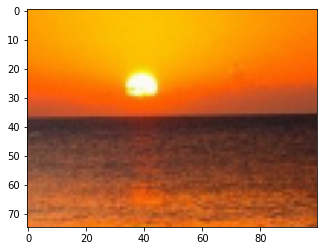

In [44]:
plt.imshow(Z1)

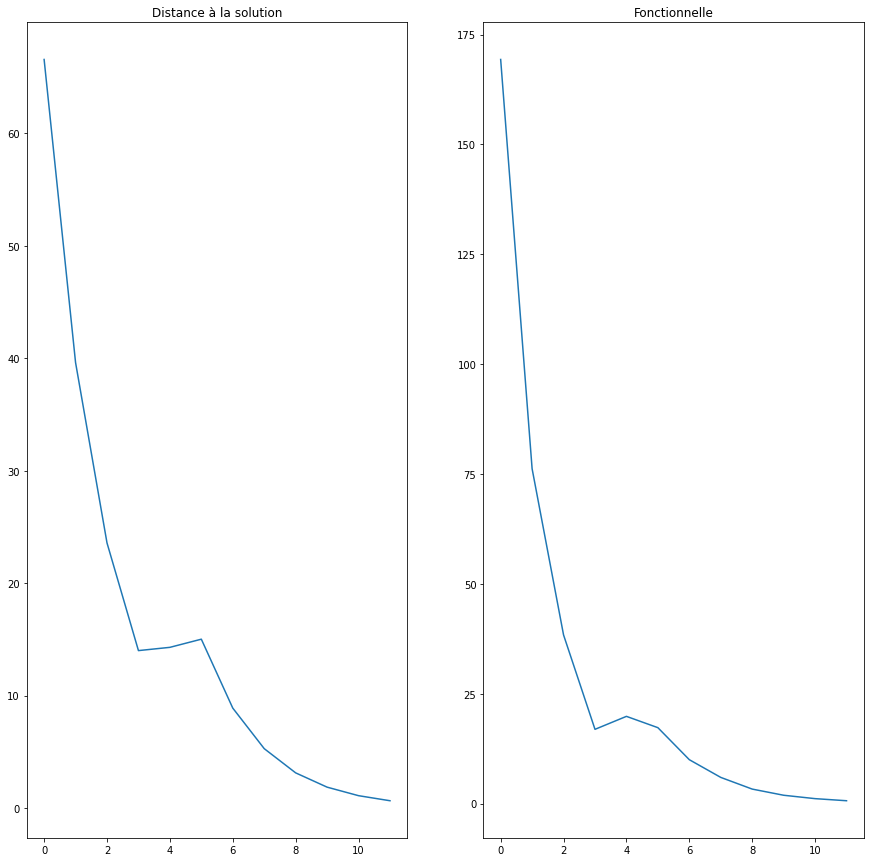

In [45]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.title("Distance à la solution")
plt.plot(ErrR)
plt.subplot(1,2,2)
plt.title("Fonctionnelle")
plt.plot(Fct)

plt.show()

# Condition de Wolfe

In [46]:
def grad_Fonctionnelle_1(Z1, X, L_H, K_ech, Lbd_H, Lbd_reg, nbProj):
    g1 = Lbd_H*SWgrad(Z1,L_H,nbProj) 
    g2 = 2*Lbd_reg*(Z1 - echantillonne_image(X, K_ech, 0))
    return g1 + g2

In [72]:
def pasWolf(out,grad,X,L_H,K_ech,Lbd_H,Lbd_reg,nbProj,sigma,teta):
    i = 0
    pasMax = 1.0
    pas = pasMax
    fct = Fonctionnelle_1(out,X,L_H, K_ech,Lbd_H,Lbd_reg,nbProj)
    g = np.linalg.norm(grad)
    while(fct-Fonctionnelle_1(out-pas*grad,X,L_H,K_ech,Lbd_H,Lbd_reg,nbProj) < sigma*pas*g**2) and (g*np.linalg.norm(grad_Fonctionnelle_1(out-pas*grad,X,L_H,K_ech,Lbd_H,Lbd_reg,nbProj)) > sigma*pas*g**2):
        pas = pasMax * teta**i
        i += 1
        if(pas <= 0.000001):
            return 0
    
    return pas


In [75]:
def gradientDescente_hyper_Wolf(L_H, X, K_ech, Lbd_H, Lbd_reg, nbProj):
    Z1 = np.random.rand(L_H.shape[0], L_H.shape[1], L_H.shape[2])
    
    ErrR=[np.linalg.norm(Z1-L_H)]#distance a l'image théorique
    Fct = [Fonctionnelle_1(Z1, X, L_H, K_ech, Lbd_H, Lbd_reg, nbProj)]#fonctionnelle a minimiser
    sigma = 10**-3
    teta = 0.2
    i = 0
    while(Fct[i] >1 & i <10000):
        grad = Lbd_H*SWgrad(Z1,L_H,nbProj) + 2*Lbd_reg*(Z1 - echantillonne_image(X, K_ech, 0))
        pas = pasWolf(Z1,grad,X,L_H,K_ech,Lbd_H, Lbd_reg,nbProj,sigma,teta)
        Z1 = Z1 - pas*grad
        Fct.append(Fonctionnelle_1(Z1, X, L_H, K_ech, Lbd_H, Lbd_reg, nbProj))
        ErrR.append(np.linalg.norm(Z1-L_H))
        if(pas == 0):
            return Z1, ErrR, Fct
        #if(i%10 == 0):
        print( 'iter = ', i ,"pas = ",pas , "fonction = ",Fonctionnelle_1(Z1, X, L_H, K_ech, Lbd_H, Lbd_reg, nbProj), "distance à la solution = " , np.linalg.norm(Z1-L_H))
        
        i = i+1

    return Z1, ErrR, Fct

In [76]:
Z1, ErrR, Fct = gradientDescente_hyper_Wolf(L_H, X, 2, 0.1, 1, 5)

iter =  0 pas =  0.2 fonction =  63.160485353012305 distance à la solution =  39.58117849919864
iter =  1 pas =  0.2 fonction =  34.91664669930187 distance à la solution =  23.517545060507665
iter =  2 pas =  0.2 fonction =  18.27622174756275 distance à la solution =  14.03740144297597
iter =  3 pas =  0.2 fonction =  9.261838166574037 distance à la solution =  8.309631799736097
iter =  4 pas =  0.2 fonction =  5.301796347649946 distance à la solution =  4.930593587103756
iter =  5 pas =  0.2 fonction =  3.0396248269553436 distance à la solution =  2.9117116038139748
iter =  6 pas =  0.2 fonction =  1.7739316625764419 distance à la solution =  1.7234952687231628
iter =  7 pas =  0.2 fonction =  1.039610263513558 distance à la solution =  1.0209350115968705
iter =  8 pas =  0.2 fonction =  0.6132472478525516 distance à la solution =  0.6067609353478504


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


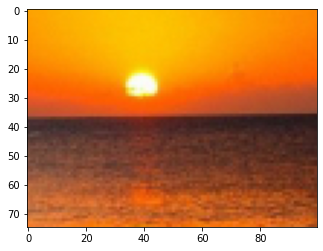

In [77]:
plt.imshow(Z1)

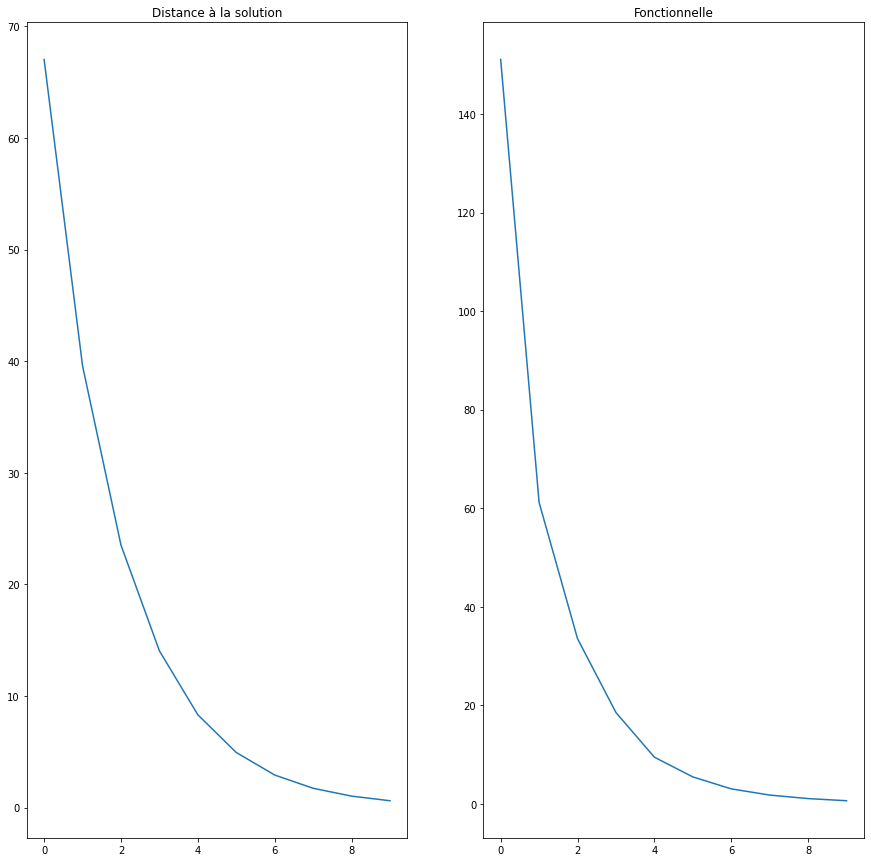

In [78]:
X = reech_interp(L_H, K_ech, order)plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.title("Distance à la solution")
plt.plot(ErrR)
plt.subplot(1,2,2)
plt.title("Fonctionnelle")
plt.plot(Fct)

plt.show()